# Full Customer Lifetime Value & RFM Analysis using Machine Learning
Business: CDNOW
---

Dataset: https://www.brucehardie.com/datasets/

Questions to answer:
- 1. Which customers have the highest spend probability in the next 90 days.
- 2. Which customers have recently purchased but are unlikely to buy.
- 3. Which customers were predicted to purchase but didnt. 

In [25]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

## Data Wrangling and Analysis

In [4]:
# Reading txt file, notice sep implementation.
df = pd.read_csv('../trash/CDNOW_master.txt', names=['customer_id', 'date', 'quantity', 'price'], sep='\s+' )

In [5]:
df

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76
...,...,...,...,...
69654,23568,19970405,4,83.74
69655,23568,19970422,1,14.99
69656,23569,19970325,2,25.74
69657,23570,19970325,3,51.12


In [6]:
# Turning 19970101 into a date (1997-01-01)
df['date'] = pd.to_datetime(df['date'].astype(str))

### Cohort Analysis

<AxesSubplot:xlabel='date'>

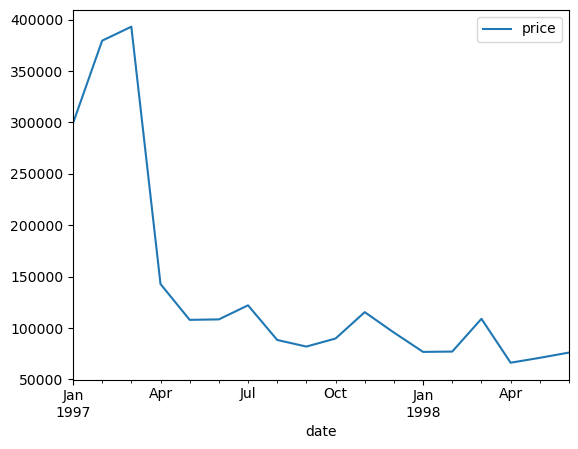

In [7]:
# Checking the trend
df.set_index('date')[['price']].resample(rule='MS').sum().plot()

In [8]:
df.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


### Machine Learning
- What will the customer spend in the next 90 days (Regression).
- What is the probability of a customer to make a purchase in the next 90 days (Classification).

#### Train Test splitting
Splitting the data into train and test dataset. When it comes to time series, training data should be the oldest one while testing is the most recent one.

In [9]:
# test data will be 90 days into the past and train data will be everything else older than 90 days
cutoff = df.date.max() - pd.to_timedelta(90, unit='d')
cutoff

Timestamp('1998-04-01 00:00:00')

In [10]:
x_raw = df[df['date'] < cutoff]
y_raw = df[df['date'] >= cutoff]
print('Train split %:', round(len(x_raw)/len(df), 2), '\nTest split %:', round(len(y_raw)/len(df), 2))

Train split %: 0.92 
Test split %: 0.08


#### Creating target (y) dataset

In [11]:
y = y_raw.groupby('customer_id')[['price']].sum().set_axis(['true_amnt_spent'], axis=1)
y['is_active'] = 1
y.head()

,true_amnt_spent,is_active
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1


#### Feature engineering for Train (X) dataset

In [12]:
# Recency. How many days back in time was the most recent purchase.

In [13]:
def last_buy_days(x, compare_to):
    val = compare_to - x.max()[1]
    return val.days

In [14]:
oldest_date = x_raw.date.max()

In [15]:
grp = x_raw.groupby('customer_id')[['customer_id', 'date']].apply(lambda x: last_buy_days(x, oldest_date))
recency = grp.to_frame().set_axis(['recency'], axis=1)
recency.head()

,recency
customer_id,
1,454
2,443
3,126
4,109
5,87


In [16]:
# Frequency. How many time each customer made a purchase.

freq = x_raw.groupby('customer_id')['date'].count().to_frame().set_axis(['frequency'], axis=1)
freq.head()

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11


In [17]:
# Average and Sum spent. How much money each user has spent and the total spent.

p = x_raw.groupby('customer_id')[['price']].agg(['sum', 'mean']).set_axis(['price_sum', 'price_mean'], axis=1)
p.head()

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455


In [18]:
# First order. When was the first order.

first_order = x_raw.groupby('customer_id')[['date']].min().set_axis(['first_order'], axis=1)
first_order.head()

,first_order
customer_id,
1,1997-01-01
2,1997-01-12
3,1997-01-02
4,1997-01-01
5,1997-01-01


In [19]:
# Purchase frequency. How often each customer performs a transaction.

pass

In [20]:
# Merging X datasets

x = pd.concat([recency, freq, p], axis=1)
x.head()

,recency,frequency,price_sum,price_mean
customer_id,,,,
1,454,1,11.77,11.770000
2,443,2,89.00,44.500000
3,126,5,139.47,27.894000
4,109,4,100.50,25.125000
5,87,11,385.61,35.055455


#### Train test split. Defining X and y datasets.

In [40]:
xy = x.join(y, how='left').fillna(0)
xy.head()

,recency,frequency,price_sum,price_mean,true_amnt_spent,is_active
customer_id,,,,,,
1,454,1,11.77,11.770000,0.00,0.0
2,443,2,89.00,44.500000,0.00,0.0
3,126,5,139.47,27.894000,16.99,1.0
4,109,4,100.50,25.125000,0.00,0.0
5,87,11,385.61,35.055455,0.00,0.0


In [41]:
x = xy[['recency', 'frequency', 'price_sum', 'price_mean']]
x.head()

,recency,frequency,price_sum,price_mean
customer_id,,,,
1,454,1,11.77,11.770000
2,443,2,89.00,44.500000
3,126,5,139.47,27.894000
4,109,4,100.50,25.125000
5,87,11,385.61,35.055455


In [64]:
y_reg = xy['true_amnt_spent']
y_cls = xy['is_active']
y_reg.head()

customer_id
1     0.00
2     0.00
3    16.99
4     0.00
5     0.00
Name: true_amnt_spent, dtype: float64

In [96]:
# Train Test Split
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
x_train_cls, x_test_cls, y_train_cls, y_test_cls = train_test_split(x, y_cls, test_size=0.2, random_state=42)

### Fitting and Testing the Machine Learning model

#### Scikit-Learn Random Forest Classifier

**Fitting Train data**

In [147]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_train_cls), columns=['y_pred'])

In [148]:
y_true = pd.DataFrame(y_train_cls.values, columns=['y_true'])

In [149]:
accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.9929465422146797

Fitting Test data

In [150]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_test_cls), columns=['y_pred'])

In [151]:
y_true = pd.DataFrame(y_test_cls.values, columns=['y_true'])

In [152]:
accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.8640220619431481

#### Scikit-Learn Random Forest Regressor

Fitting Train data

In [165]:
model = RandomForestRegressor(random_state=42)

model.fit(x_train_reg, y_train_reg)
y_pred = pd.DataFrame(model.predict(x_train_reg), columns=['y_pred'])

y_true = pd.DataFrame(y_train_reg.values, columns=['y_true'])

r2_score(y_true['y_true'], y_pred['y_pred'])

0.9100212816107602

Fitting Test data

In [166]:
model = RandomForestRegressor(random_state=42)

model.fit(x_train_reg, y_train_reg)
y_pred = pd.DataFrame(model.predict(x_test_reg), columns=['y_pred'])

y_true = pd.DataFrame(y_test_reg.values, columns=['y_true'])

r2_score(y_true['y_true'], y_pred['y_pred'])

0.3817767458951121

In [ ]:
model = GridSearchCV(estimator=model_reg, 
                     param_grid=dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), 
                     scoring='neg_mean_absolute_error',
                     refit=True, 
                     cv=5)